- loop over positions from memoryview
    - STEP 1: calculate activation $r_{in}$ at new position for each input layer neuron $j$
    - STEP 2: calculate input $h$ for each output neuron $i$
        - for each output neuron $i$ sum over all input neuron activations $r_j$ * weight$_{ij}$
    - STEP 3: calculate output $r_i$ for each output neuron $i$
        - check if mean and sparseness of activity for all output neurons together are within 10% error bounds
        - if not, adjust $g$ and $\mu$
        - only do this for a maximum of 100 iterations at each time step
    - STEP 4: adjust the weights using the running average of input and output firing rates
    - STEP 5: re-normalize the weights to unit norm
        - this can be done using a memoryview to change current weights in place

In [4]:
%load_ext Cython

In [246]:
%%cython
from __future__ import print_function
import numpy as np
cimport numpy as np
cimport cython
from libc cimport math
from math import pi


def simulate(
    path, # the pre-calculated path with shape(t, 2)
    pref_loc, # preferred firing locations of the input neurons with shape(N_in, 2)
    dt = 0.01,
    N_in = 400, # number of input neurons
    N_out = 100, # number of output neurons
    n_snapshots = 20, # number of saved states of weights etc.
    tau_plus = 0.1,
    tau_minus = 0.3,
    a_0 = 0.1,
    s_0 = 0.3,
    errorbound = 0.1,
    sigma = 0.05,
    ):
    
    weights = c_simulate(
        path,
        pref_loc,
        dt,
        N_in,
        N_out,
        n_snapshots,
        tau_plus,
        tau_minus,
        a_0,
        s_0,
        errorbound,
        sigma,
        )
    
    return weights

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off zero-division checking
cdef double heaviside(double x) nogil:
    if x >= 0.0:        
        return 1.0
    else:
        return 0.0

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
# @cython.cdivision(True) # turn off zero-division checking
cdef c_simulate(
    double[:, :] path, # a memoryview into the path ndarray
    double[:, :] pref_loc, # a memoryview into the preferred locations of the input neurons
    double dt,
    int N_in,
    int N_out,
    int n_snapshots,
    double tau_plus,
    double tau_minus,
    double a_0,
    double s_0,
    double errorbound,
    double sigma,
    ):
    
    
    cdef int steps = path.shape[0]
    cdef Py_ssize_t t
    cdef Py_ssize_t i
    cdef Py_ssize_t j
    cdef int maxiterations = 100
    cdef int it
    cdef double mu
    cdef double g
    cdef double PI = pi
    cdef double b3 = 0.01
    cdef double b4 = 0.1
    cdef double eta = 0.05
    cdef double epsilon = 0.005
    cdef double a = 0
    cdef double s = 0
    cdef double r_out_accumulator
    cdef double r_out_squared_accum
    
    assert(pref_loc.shape[0] == N_in)
    
    # initialize all needed arrays and assign memoryviews:
    # input neuron rates
    r_in_arr = np.zeros(N_in, dtype=np.float64)
    cdef double[:] r_in = r_in_arr
    
    # output neuron rates
    r_out_arr = np.zeros(N_out, dtype=np.float64)
    cdef double[:] r_out = r_out_arr
    
    # input for output neurons
    h_arr = np.zeros(N_out, dtype=np.float64)
    cdef double[:] h = h_arr
    
    # weights between input and output neurons
    w_arr = np.random.uniform(size=(N_out, N_in))
    normalization = 1 / np.sqrt(np.sum(w_arr ** 2.0, axis=1)) 
    w_arr *= normalization[:, np.newaxis]
    cdef double[:, :] w = w_arr
    
    # dynamical variables
    r_plus_arr = np.zeros(N_out, dtype=np.float64)
    cdef double[:] r_plus = r_plus_arr
    r_minus_arr = np.zeros(N_out, dtype=np.float64)
    cdef double[:] r_minus = r_minus_arr
    
    # running averages
    r_out_run_arr = np.zeros(N_out, dtype=np.float64)
    cdef double[:] r_out_run = r_out_run_arr
    r_in_run_arr = np.zeros(N_in, dtype=np.float64)
    cdef double[:] r_in_run = r_in_run_arr
    
    # weight accumulator
    weight_accumulator_arr = np.zeros(N_out, dtype=np.float64)
    cdef double[:] weight_accumulator = weight_accumulator_arr
    
    
    for t in range(steps):
        
        # STEP 1
        for j in range(N_in):
            # calculate activation of each input neuron
            r_in[j] = math.exp(
                - (
                    (path[t, 0] - pref_loc[j, 0]) ** 2.0 +
                    (path[t, 1] - pref_loc[j, 1]) ** 2.0
                ) / (2.0 * sigma ** 2.0)
            )
            
            # calculate running average of input neuron activation
            r_in_run[j] += eta * (r_in[j] - r_in_run[j]) # no t-1 because we replace the value instead of progressing to the next. so i on the right is at t-1 if i on the left is at t
        
        
        
        
        # STEP 2
        for i in range(N_out):
            # calculate activation of each output neuron
            for j in range(N_in):
                # accumulate activity fed into output neuron j
                h[i] += w[i, j] * r_in[j]
                
            # integrate activation variables and replace directly (no t and t-1)
            r_plus[i] += dt * ((h[i] - r_plus[i] - r_minus[i]) / tau_plus)
            r_minus[i] += dt * ((h[i] - r_minus[i]) / tau_minus)

#         print("step %i:" % t)
#         print("r+: ", end="")
#         print(r_plus_arr)
#         print("r-: ", end="")
#         print(r_minus_arr)        

        
        

        # TODO find out real starting values for these
        mu = 0
        g = 1
        
        # STEP 3
        for it in range(maxiterations):
#             print("iteration %i: " % it)
#             print("mu: %.3f, g: %.3f" % (mu, g))
            
            # reset activity accumulators
            r_out_accumulator = 0
            r_out_squared_accum = 0
            
            for i in range(N_out):
                # calculate output rate of output neurons
                r_out[i] = 2 / PI * (
                    math.atan(g * (r_plus[i] - mu)) * heaviside(r_plus[i] - mu)
                )
                
                # accumulate activity for calculation of activity and sparseness measures
                r_out_accumulator += r_out[i]
                r_out_squared_accum += r_out[i] ** 2
                
            # DEBUG:    
            if r_out_squared_accum == 0:
                print("Zero Division error at step: %i" % t)
                print("iteration: %i" % it)
                print("r_in:")
                print(r_in_arr)
                print("\nr_out:")
                print(r_out_arr)
                print("\nh")
                print(h_arr)
                print("\nr_plus:")
                print(r_plus_arr)
                print("\nr_minus:")
                print(r_minus_arr)
                
                print("\nmu: %.12f, g: %.12f" % (mu, g))
                
            a = r_out_accumulator / N_out
            s = (r_out_accumulator ** 2) / (N_out * r_out_squared_accum)
#             print("accumulated activity: %.12f, a: %.12f, s: %.12f\n" % (r_out_accumulator, a, s))
            
            
            # if bounds are met finish the iterative for loop
            if (((a_0 * (1 - errorbound)) <= a <= (a_0 * (1 + errorbound)))
                and ((s_0 * (1 - errorbound)) <= s <= (s_0 * (1 + errorbound)))):
#                 print(it)
                break                
            
            # else change mu and g
            mu += b3 * (a - a_0)
            g += b4 * g  * (s - s_0) 
        
        
        
        # STEP 4

        for i in range(N_out):
            # calculate output firing rate running average
            r_out_run[i] += eta * (r_out[i] - r_out_run[i]) # no t-1 because we replace the value instead of progressing to the next. so i on the right is at t-1 if i on the left is at t
            
            # reset weight_accumulator
            weight_accumulator[i] = 0.0
            
            for j in range(N_in):
                # loop over all weights and update them in-place depending
                # on the learning dynamics
                w[i, j] += epsilon * (r_out[i] * r_in[j] - r_out_run[i] * r_in_run[j])                
                # accumulate the sum for normalization of each output neuron at the same time
                weight_accumulator[i] += w[i, j]         
        
        
        
        # STEP 5
        
        for i in range(N_out):
            for j in range(N_in):               
                # loop over the weights again and multiply
                # with normalization factor in-place
                w[i, j] /= weight_accumulator[i]
            
        # save weight and firing rate states into snapshot arrays
        
    # TODO: return various calculated snapshot arrays
    return w_arr

In [256]:
path = np.load("rat_path_1h.npy")
# path = np.array([[0.6, 0.6], [0.61, 0.61]])


x_axis = np.linspace(0, 0.95, 20) #grid point spaced 5cm apart in meters
x, y = np.meshgrid(x_axis, x_axis)
pref_loc = np.vstack((x.flatten(),y.flatten())).T

limit_steps = 10000
weights = simulate(path[0:limit_steps, :], pref_loc, N_in=400, N_out=100, dt=0.01)

Zero Division error at step: 9530
iteration: 99
r_in:
[  7.97210778e-162   3.14170601e-157   4.55473844e-153   2.42922007e-149
   4.76623878e-146   3.44025195e-143   9.13503513e-141   8.92350994e-139
   3.20676194e-137   4.23938878e-136   2.06179409e-135   3.68886577e-135
   2.42798463e-135   5.87901451e-136   5.23683209e-137   1.71608298e-138
   2.06877584e-140   9.17474722e-143   1.49685695e-145   8.98404677e-149
   3.09208110e-151   1.21854973e-146   1.76661192e-142   9.42203199e-139
   1.84864496e-135   1.33434448e-132   3.54313693e-130   3.46109425e-128
   1.24378248e-126   1.64429964e-125   7.99692467e-125   1.43077244e-124
   9.41724020e-125   2.28024886e-125   2.03117042e-126   6.65604115e-128
   8.02400427e-130   3.55853976e-132   5.80574573e-135   3.48457421e-138
   4.41198582e-141   1.73870735e-136   2.52071874e-132   1.34439784e-128
   2.63776890e-125   1.90393096e-122   5.05558211e-120   4.93851820e-118
   1.77471110e-116   2.34619548e-115   1.14105410e-114   2.04152076e-1

ZeroDivisionError: float division

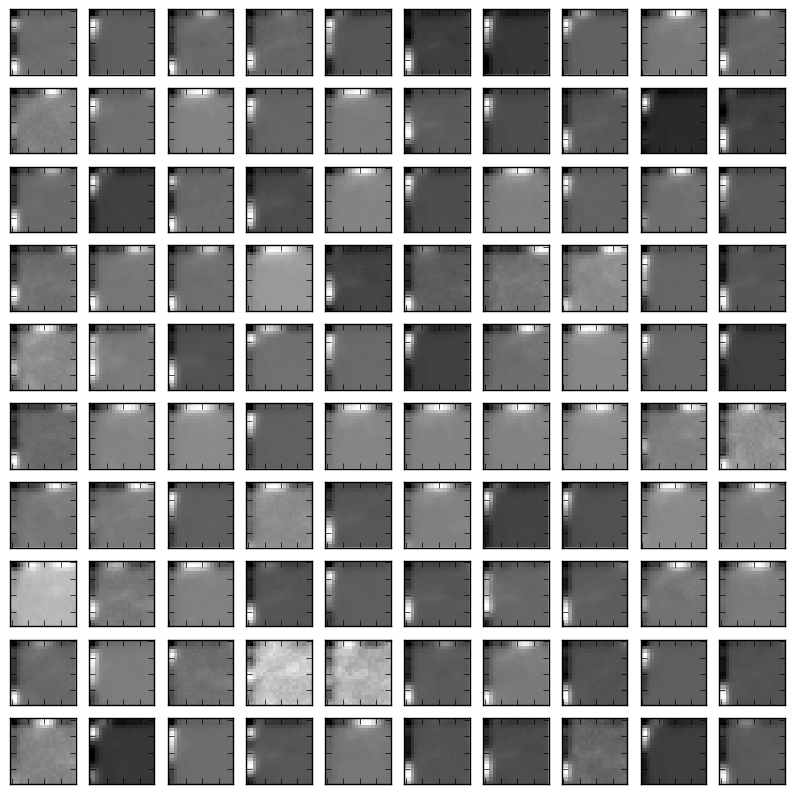

100.0

In [250]:
fig, sps = plt.subplots(10, 10)
for i, sp in enumerate(sps.flat):
    sp.imshow(weights.reshape(100,20,20)[i, ...].squeeze(), interpolation="None", cmap="gray")
    sp.set_xlabel("")
    sp.set_ylabel("")
    sp.set_xticklabels("")
    sp.set_yticklabels("")

fig.set_size_inches(10, 10)
plt.show()
weights.sum()

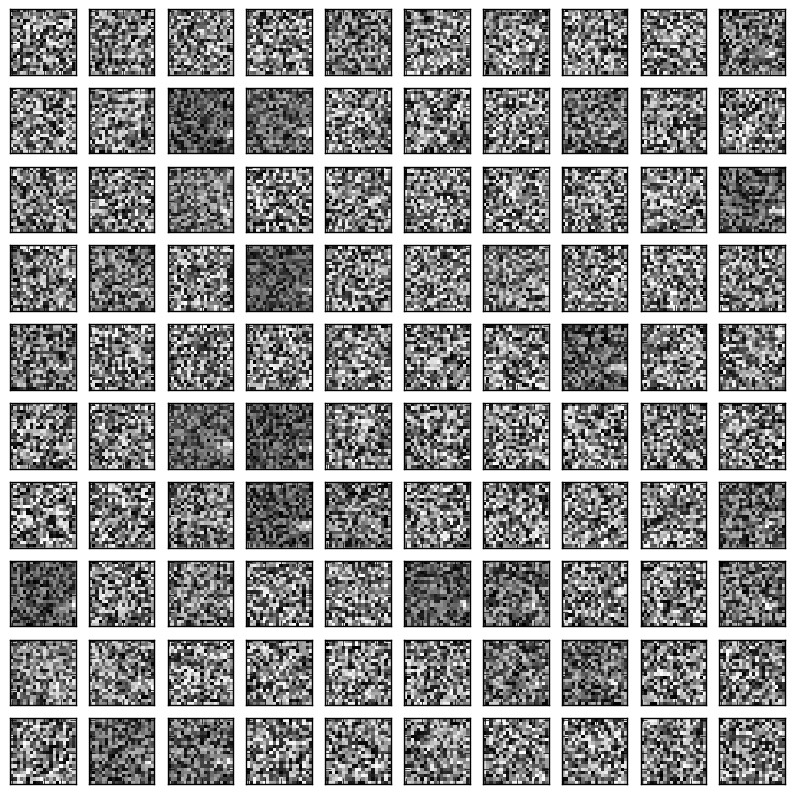

100.00000000000001

In [227]:
fig, sps = plt.subplots(10, 10)
for i, sp in enumerate(sps.flat):
    sp.imshow(weights.reshape(100,20,20)[i, ...].squeeze(), interpolation="None", cmap="gray")
    sp.set_xlabel("")
    sp.set_ylabel("")
    sp.set_xticklabels("")
    sp.set_yticklabels("")

fig.set_size_inches(10, 10)
plt.show()
weights.sum()

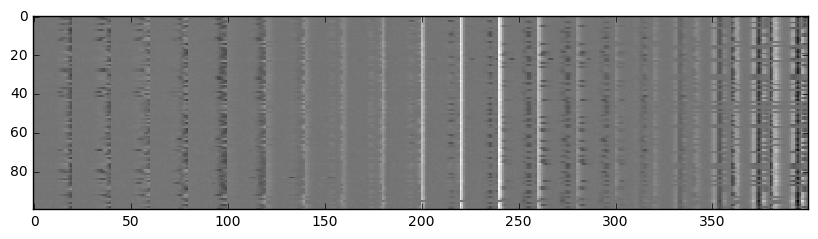

100.0

In [217]:
import matplotlib.pyplot as plt
fig, sp = plt.subplots(1)
sp.imshow(weights, interpolation="None", cmap="gray")
fig.set_size_inches(10, 10)
plt.show()
weights.sum()

In [257]:
path[9530,:]

array([ 0.55408713,  1.24406657])

In [202]:
1/0.3

3.3333333333333335